# Neural Network Temperature and Humidity
Granularity

In [169]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
from numpy import array
import datetime
from keras.models import Sequential
from keras.layers import Dense

## Load Official Weather Data Observations

readings every hour

In [183]:
# parse the DWD dataset and convert date and align with home readings 
# Format dwd: yyyymmddhh
df = pd.read_csv('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt', sep=';')

# parse date
df.insert(2, 'datetime', pd.to_datetime(df['MESS_DATUM'], errors='coerce', format='%Y%m%d%H'))

# create index
df.set_index('datetime', inplace=True)

# extract relevant columns and rename, subset
df.rename(columns={'TT_TU':'D_Temp','RF_TU':'D_Humi'}, inplace=True)

# filter years
filter = (df.index.year >= 2013) & (df.index.year <= 2014) 

df = df.loc[filter,['D_Temp', 'D_Humi']]
df.head()

,D_Temp,D_Humi
datetime,,
2013-01-01 00:00:00,8.4,70.0
2013-01-01 01:00:00,8.4,70.0
2013-01-01 02:00:00,8.4,69.0
2013-01-01 03:00:00,8.7,68.0
2013-01-01 04:00:00,8.5,69.0


In [184]:
# Remove erroneous data points 
df.shape

(17475, 2)

In [185]:
## drop erroneous data points
dropidx = df[df.D_Humi < 0 ].index
df.drop(dropidx, inplace=True)
df.loc[df['D_Humi'] < 0]

,D_Temp,D_Humi
datetime,,


In [186]:
# compute daily average : fill in nans created during resampling with the nearest value
timestep = 'D'
df = df.resample(timestep).nearest()
df.head()

,D_Temp,D_Humi
datetime,,
2013-01-01,8.4,70.0
2013-01-02,3.9,85.0
2013-01-03,5.9,78.0
2013-01-04,8.8,90.0
2013-01-05,8.6,94.0


In [204]:
# check to see if any nan still exist after filling na
pd.isnull(df).any(1).nonzero()[0]

array([], dtype=int64)

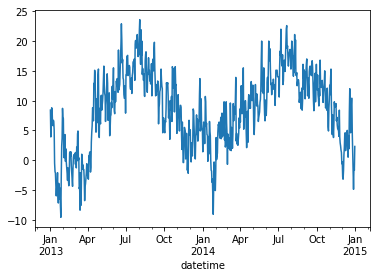

In [208]:
df.D_Temp.plot()

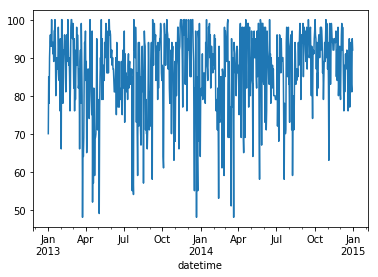

In [212]:
df.D_Humi.plot()

In [209]:
# list index and get the posistion of Dec 31
df.index.get_loc('2013-12-31')

364

In [210]:
df.index.get_loc('2014-01-01')

365

In [214]:
# select single variable for building model
sensor = 'D_Temp'
X = np.array(df[sensor])
len(X)

730

## Subset Data

## Split data into sequences 

In [215]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

## Build Train and Test Set
Define input sequence and choose a number of time steps

In [216]:
n_steps = 3
# split into samples
X, y = split_sequence(X, n_steps)

In [217]:
# look at what the splits
print('Number observations {}'.format(len(X)))
for i in range(20):
    print(X[i], y[i])

Number observations 727
[8.4 3.9 5.9] 8.8
[3.9 5.9 8.8] 8.6
[5.9 8.8 8.6] 6.2
[8.8 8.6 6.2] 5.8
[8.6 6.2 5.8] 6.7
[6.2 5.8 6.7] 6.5
[5.8 6.7 6.5] 5.1
[6.7 6.5 5.1] -0.5
[ 6.5  5.1 -0.5] -1.9
[ 5.1 -0.5 -1.9] -2.2
[-0.5 -1.9 -2.2] -4.2
[-1.9 -2.2 -4.2] -6.0
[-2.2 -4.2 -6. ] -4.7
[-4.2 -6.  -4.7] -4.3
[-6.  -4.7 -4.3] -2.1
[-4.7 -4.3 -2.1] -5.5
[-4.3 -2.1 -5.5] -7.2
[-2.1 -5.5 -7.2] -3.9
[-5.5 -7.2 -3.9] -6.4
[-7.2 -3.9 -6.4] -6.5


In [260]:
## create a train and test set
xtrain  = X[0:364,:]
ytrain = y[0:364]

# evaluate model performance validation 
min_index =  365
max_index = 565
xval  = X[min_index:max_index,:]
yval = y[min_index:max_index]

#print('xval {}'.format(xval))
#print('yval {}'.format(yval))

validation_data = (xval, yval)
validation_data

(array([[ 1.4,  3.8,  6.4],
        [ 3.8,  6.4,  5.8],
        [ 6.4,  5.8,  2.8],
        [ 5.8,  2.8,  2.8],
        [ 2.8,  2.8, 10.7],
        [ 2.8, 10.7,  9.8],
        [10.7,  9.8,  5.7],
        [ 9.8,  5.7,  6.2],
        [ 5.7,  6.2,  4.3],
        [ 6.2,  4.3,  4.2],
        [ 4.3,  4.2, -0.2],
        [ 4.2, -0.2,  3.9],
        [-0.2,  3.9,  1. ],
        [ 3.9,  1. ,  2.3],
        [ 1. ,  2.3,  6.5],
        [ 2.3,  6.5,  4.8],
        [ 6.5,  4.8,  4.1],
        [ 4.8,  4.1,  0. ],
        [ 4.1,  0. , -1.7],
        [ 0. , -1.7, -1.8],
        [-1.7, -1.8, -3.7],
        [-1.8, -3.7, -3.2],
        [-3.7, -3.2, -6.3],
        [-3.2, -6.3, -9.1],
        [-6.3, -9.1, -4.9],
        [-9.1, -4.9, -0.3],
        [-4.9, -0.3, -1.3],
        [-0.3, -1.3, -4.7],
        [-1.3, -4.7, -5.1],
        [-4.7, -5.1, -1.8],
        [-5.1, -1.8,  3.8],
        [-1.8,  3.8,  0.1],
        [ 3.8,  0.1,  0.6],
        [ 0.1,  0.6,  1.2],
        [ 0.6,  1.2,  4.7],
        [ 1.2,  4.7,

## Train and test a model: 

TODO: Explain : relu, adam, mse, epoch, architecture?

First Results: Univariate MLP is not doing so badly; more epochs did not produce better results; running multiple times yields slightly difference results 

In [249]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
# fit model
history = model.fit(xtrain, ytrain, epochs=100, verbose=1)

Epoch 1/100
364/364 [==============================] - 0s 989us/step - loss: 5.0082
Epoch 2/100
364/364 [==============================] - 0s 95us/step - loss: 2.8747
Epoch 3/100
364/364 [==============================] - 0s 68us/step - loss: 2.5340
Epoch 4/100
364/364 [==============================] - 0s 70us/step - loss: 2.5047
Epoch 5/100
364/364 [==============================] - 0s 73us/step - loss: 2.3947
Epoch 6/100
364/364 [==============================] - 0s 68us/step - loss: 2.3605
Epoch 7/100
364/364 [==============================] - 0s 60us/step - loss: 2.3560
Epoch 8/100
364/364 [==============================] - 0s 73us/step - loss: 2.3215
Epoch 9/100
364/364 [==============================] - 0s 83us/step - loss: 2.3069
Epoch 10/100
364/364 [==============================] - 0s 55us/step - loss: 2.2977
Epoch 11/100
364/364 [==============================] - 0s 67us/step - loss: 2.2759
Epoch 12/100
364/364 [==============================] - 0s 61us/step - loss: 2.2649


In [253]:


x_input = xtest.reshape((1, n_steps))
ypredict = model.predict(x_input, verbose=1)
print(ypredict)

xval [[ 1.4  3.8  6.4]
 [ 3.8  6.4  5.8]
 [ 6.4  5.8  2.8]
 [ 5.8  2.8  2.8]
 [ 2.8  2.8 10.7]
 [ 2.8 10.7  9.8]
 [10.7  9.8  5.7]
 [ 9.8  5.7  6.2]
 [ 5.7  6.2  4.3]
 [ 6.2  4.3  4.2]
 [ 4.3  4.2 -0.2]
 [ 4.2 -0.2  3.9]
 [-0.2  3.9  1. ]
 [ 3.9  1.   2.3]
 [ 1.   2.3  6.5]
 [ 2.3  6.5  4.8]
 [ 6.5  4.8  4.1]
 [ 4.8  4.1  0. ]
 [ 4.1  0.  -1.7]
 [ 0.  -1.7 -1.8]
 [-1.7 -1.8 -3.7]
 [-1.8 -3.7 -3.2]
 [-3.7 -3.2 -6.3]
 [-3.2 -6.3 -9.1]
 [-6.3 -9.1 -4.9]
 [-9.1 -4.9 -0.3]
 [-4.9 -0.3 -1.3]
 [-0.3 -1.3 -4.7]
 [-1.3 -4.7 -5.1]
 [-4.7 -5.1 -1.8]
 [-5.1 -1.8  3.8]
 [-1.8  3.8  0.1]
 [ 3.8  0.1  0.6]
 [ 0.1  0.6  1.2]
 [ 0.6  1.2  4.7]
 [ 1.2  4.7  6. ]
 [ 4.7  6.   5.8]
 [ 6.   5.8  6.4]
 [ 5.8  6.4  4.2]
 [ 6.4  4.2  3.7]
 [ 4.2  3.7  5.2]
 [ 3.7  5.2  7.2]
 [ 5.2  7.2  3.6]
 [ 7.2  3.6  6.1]
 [ 3.6  6.1  7.9]
 [ 6.1  7.9  3.9]
 [ 7.9  3.9  4.7]
 [ 3.9  4.7  4.2]
 [ 4.7  4.2  6. ]
 [ 4.2  6.   9.8]
 [ 6.   9.8  3.4]
 [ 9.8  3.4  4.2]
 [ 3.4  4.2  2.2]
 [ 4.2  2.2  2.7]
 [ 2.2  2.7  9.8]
 [ 2.

ValueError: cannot reshape array of size 600 into shape (1,3)

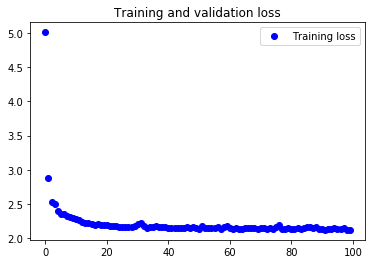

In [250]:
import matplotlib.pyplot as plt

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Conversation Cafe:

How far into the future can predict with current model  
How good is a model for humidity
Do we can better prediction if we use 2 years of data?
What else could we predict besides temperature?
Do we get better results if we normalize the data before training?
How good is our model?